In [1]:
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.visualize import view
from ase.build import surface

### Read cif file

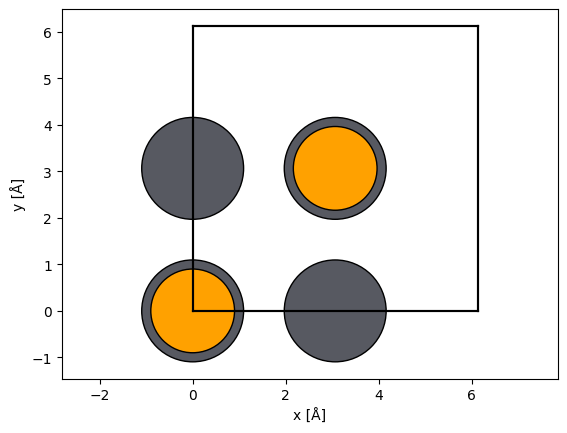

In [2]:
PbSe = ase.io.read("PbSe.cif")
abtem.show_atoms(PbSe);

### Create a 110 surface

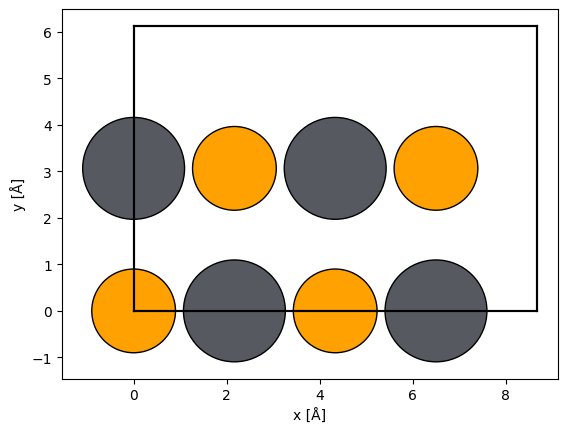

In [3]:
PbSe_110 = surface(PbSe, indices=(1, 1, 0), layers=3, periodic=True)

abtem.show_atoms(PbSe_110, plane="xy");

### Expand the cell

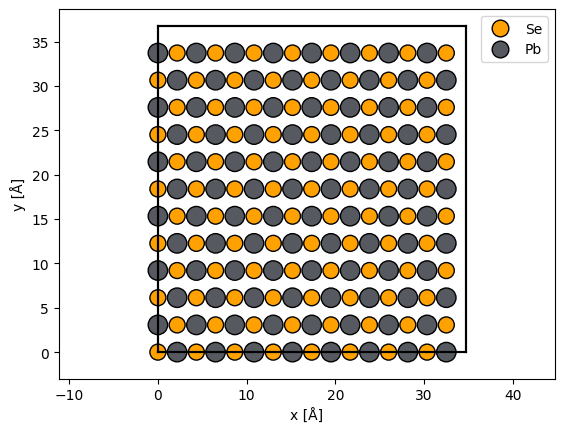

In [4]:
repeated_PbSe = PbSe_110.copy()

repeated_PbSe *= (4, 6, 4)

abtem.show_atoms(repeated_PbSe, legend=True);

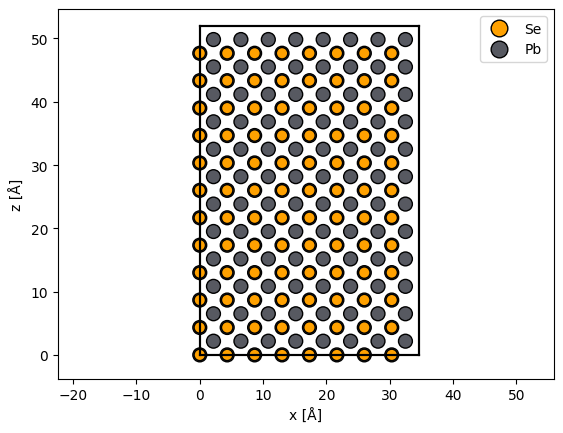

In [5]:
abtem.show_atoms(repeated_PbSe, legend=True, plane='xz');

In [6]:
from ase.io import write

write("PbSe_110.cif", repeated_PbSe)

### Build Atomic Potential

In [7]:
%matplotlib ipympl

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

# np.set_printoptions(edgeitems=2)

abtem.config.set({"visualize.cmap": "plasma"})
abtem.config.set({"visualize.continuous_update": True})
abtem.config.set({"visualize.autoscale": True})
# abtem.config.set({"visualize.reciprocal_space_units": "mrad"})
abtem.config.set({"device": "cpu"})
abtem.config.set({"fft": "fftw"});

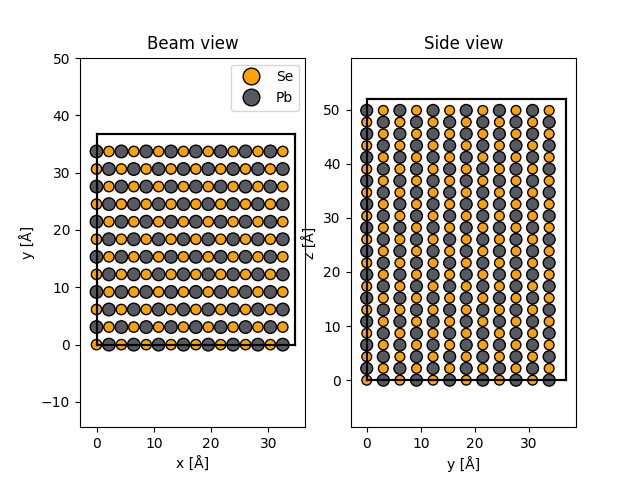

In [8]:
PbSe_110 = ase.io.read("PbSe_110.cif")

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(PbSe_110, ax=ax1, plane="xy", title="Beam view", legend=True)
abtem.show_atoms(PbSe_110, ax=ax2, plane="yz", title="Side view");

### Set the sampling rate

In [9]:
potential = abtem.Potential(PbSe_110, sampling=0.05, slice_thickness=2)

In [10]:
len(potential)

26

### Compute the potential

In [11]:
potential_array = potential.build()

In [12]:
potential_array.array

dask.array<_wrap_build_potential, shape=(26, 694, 736), dtype=float32, chunksize=(26, 694, 736), chunktype=numpy.ndarray>

In [13]:
potential_array.compute()

[########################################] | 100% Completed | 3.39 ss


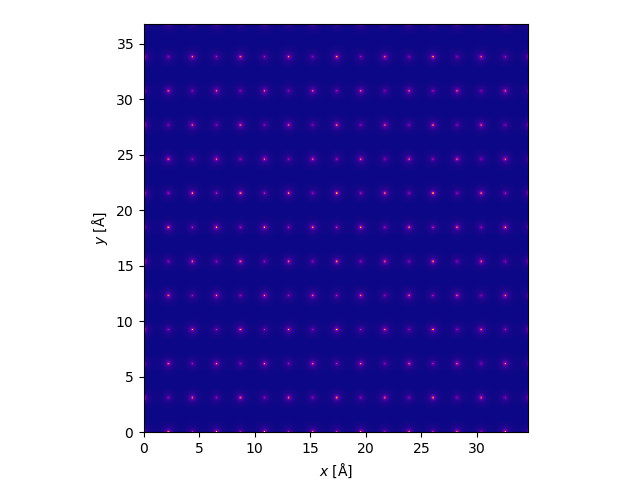

In [14]:
potential_array.show();

In [15]:
potential_array.to_images().show(interact=True, cbar=True);

In [16]:
probe = abtem.Probe(energy=200e3, defocus=25, semiangle_cutoff=27.5)

In [17]:
probe.grid.match(potential)

In [18]:
probe_waves = probe.build()

probe_waves.array

dask.array<getitem, shape=(694, 736), dtype=complex64, chunksize=(694, 736), chunktype=numpy.ndarray>

In [19]:
probe_waves.compute()

[########################################] | 100% Completed | 431.79 ms


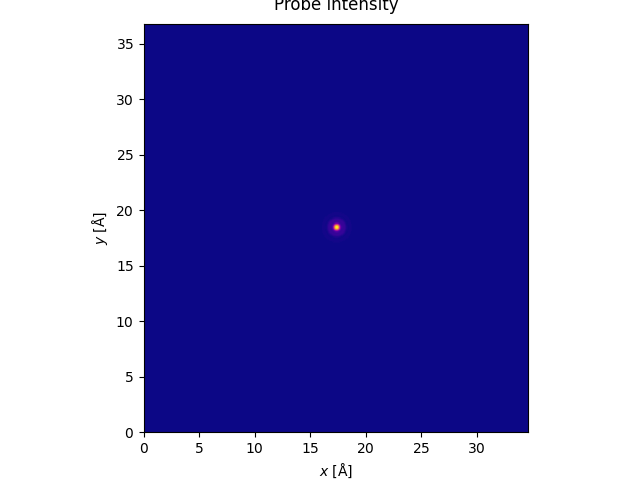

In [20]:
probe_waves.intensity().show(title="Probe intensity")

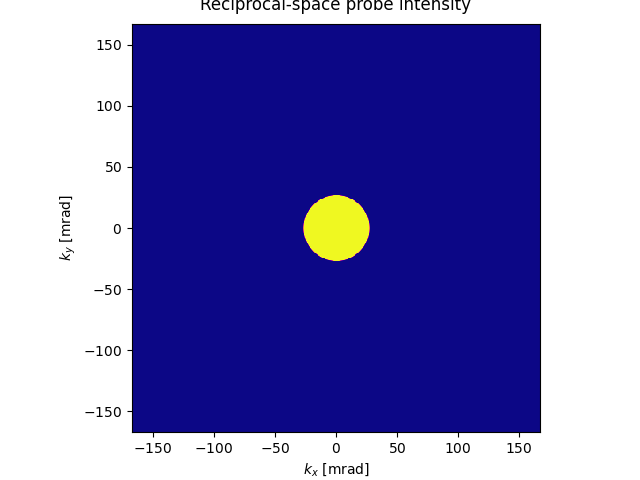

In [21]:
probe_waves.diffraction_patterns().show(
    title="Reciprocal-space probe intensity", units="mrad"
);

### Set the scanning grid

In [22]:
scan = abtem.GridScan(
    start=(0, 0),
    end=(1/8, 1/6),
    sampling=probe.ctf.nyquist_sampling,
    fractional=True,
    potential=potential,
)

D:\Anaconda_\Anaconda\envs\abtem\lib\site-packages\abtem\scan.py:1007: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle(


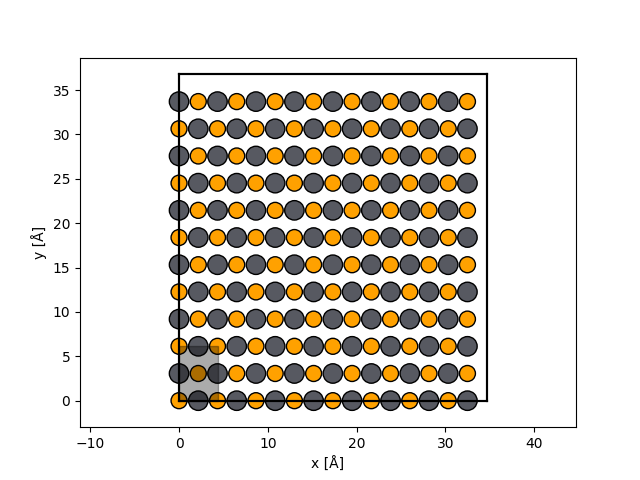

In [23]:
fig, ax = abtem.show_atoms(PbSe_110)
scan.add_to_plot(ax, color="k");

### Set the detector

In [24]:
bright = abtem.AnnularDetector(inner=0, outer=20)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=100, outer=180)

detectors = [bright, maadf, haadf]

In [25]:
print(f"alpha_max = {min(probe.cutoff_angles):.1f} mrad")

alpha_max = 167.1 mrad


In [26]:
bright_region = bright.get_detector_region(probe)
maadf_region = maadf.get_detector_region(probe)
haadf_region = haadf.get_detector_region(probe)

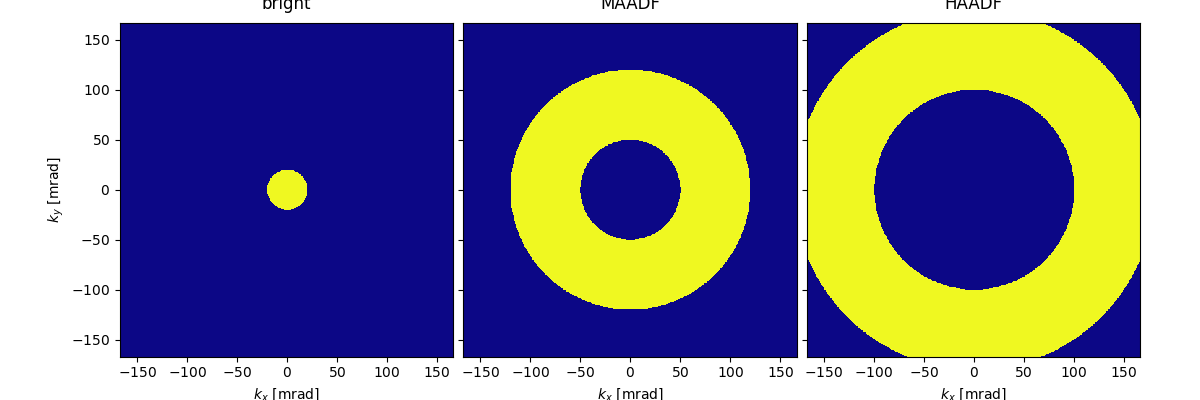

In [27]:
stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(explode=True, units="mrad", figsize=(12, 4))

In [28]:
scanned_measurements = probe.scan(
    scan=scan,
    detectors=detectors,
    potential=potential,
)

scanned_measurements.compute()

[########################################] | 100% Completed | 88.23 s


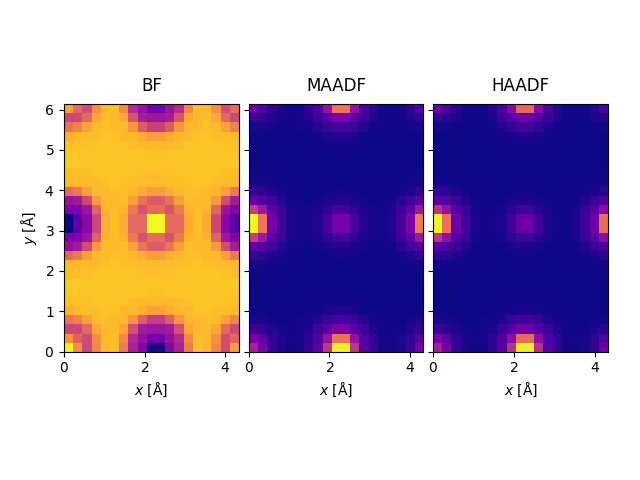

In [29]:
stacked_measurements = abtem.stack(scanned_measurements, ("BF", "MAADF", "HAADF"))

stacked_measurements.show(explode=True);

### Interpolate the result

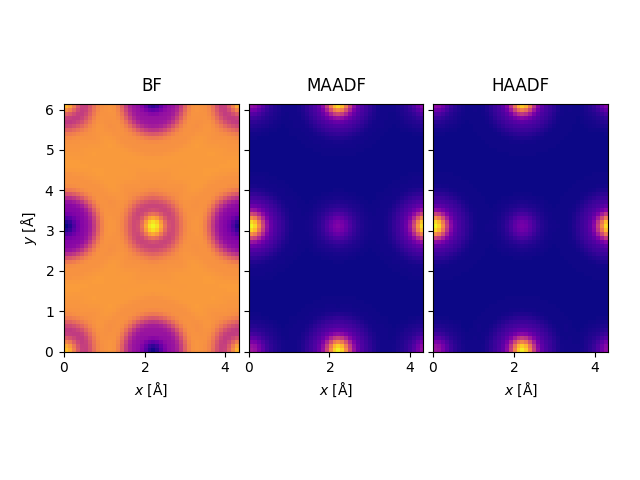

In [30]:
interpolated_measurements = stacked_measurements.interpolate(0.1)

interpolated_measurements.show(explode=True);

### Blurring

D:\Anaconda_\Anaconda\envs\abtem\lib\site-packages\abtem\visualize.py:400: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


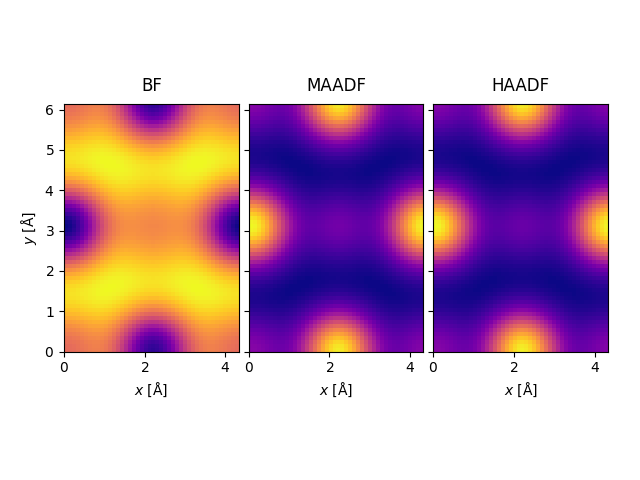

In [49]:
blurred_measurements = interpolated_measurements.gaussian_filter(0.55)

blurred_measurements.show(explode=True);

In [50]:
tiled_measurements = blurred_measurements.tile((40, 28))

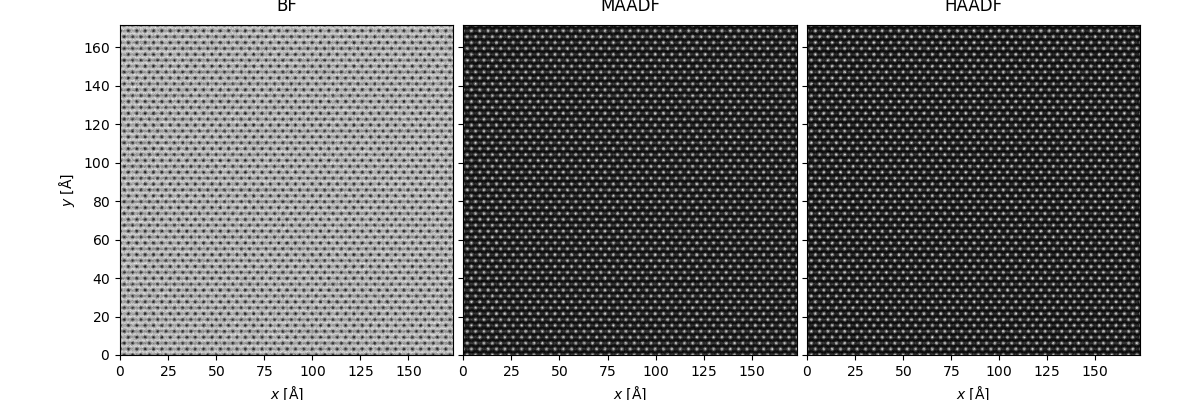

In [51]:
noisy_measurements = tiled_measurements.poisson_noise(dose_per_area=4e5, seed=100)

noisy_measurements.show(explode=True, figsize=(12, 4),cmap='gray');

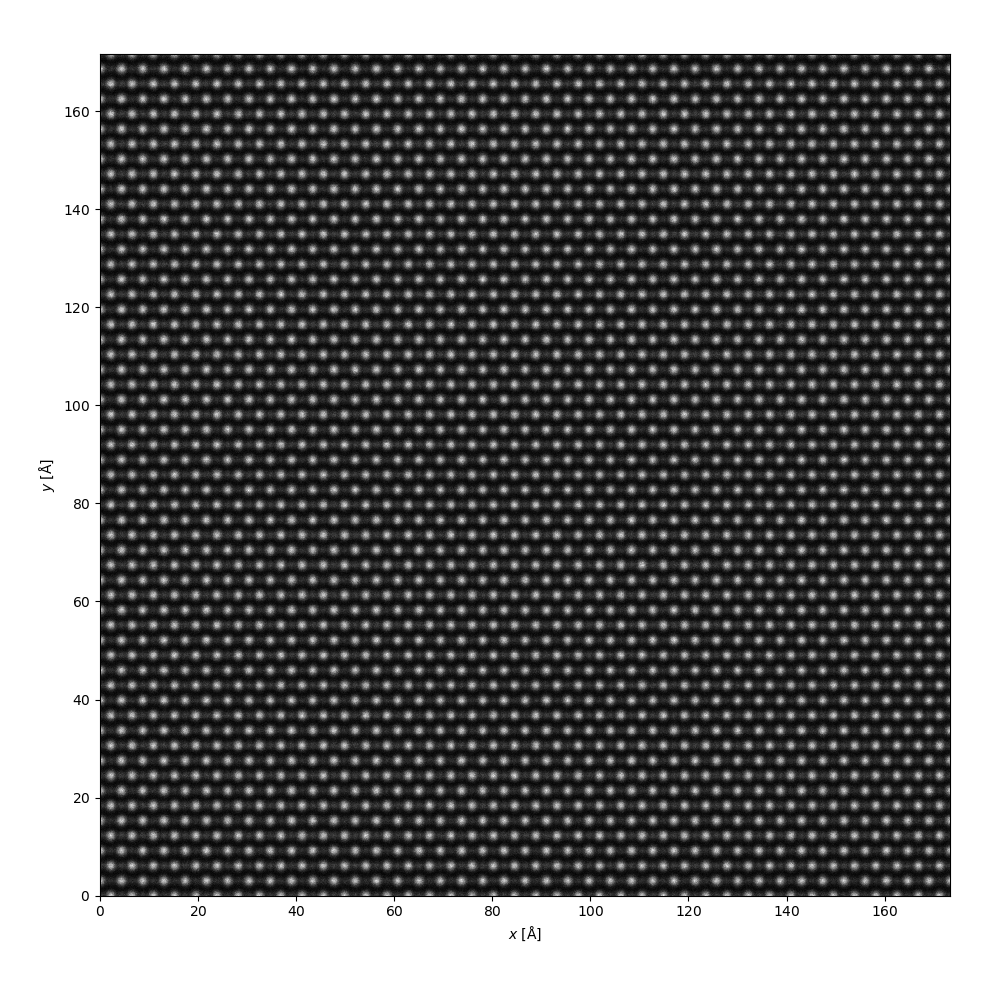

In [52]:
noisy_measurements[2].show(figsize=(10,10),cmap='gray')

In [53]:
np.save('PbSe_HAADF_highI_large.npy', noisy_measurements[2].array)    # .npy extension is added if not given
np.save('PbSe_HAADF_scale_A_highI_large.npy', noisy_measurements[2].sampling)    # .npy extension is added if not given

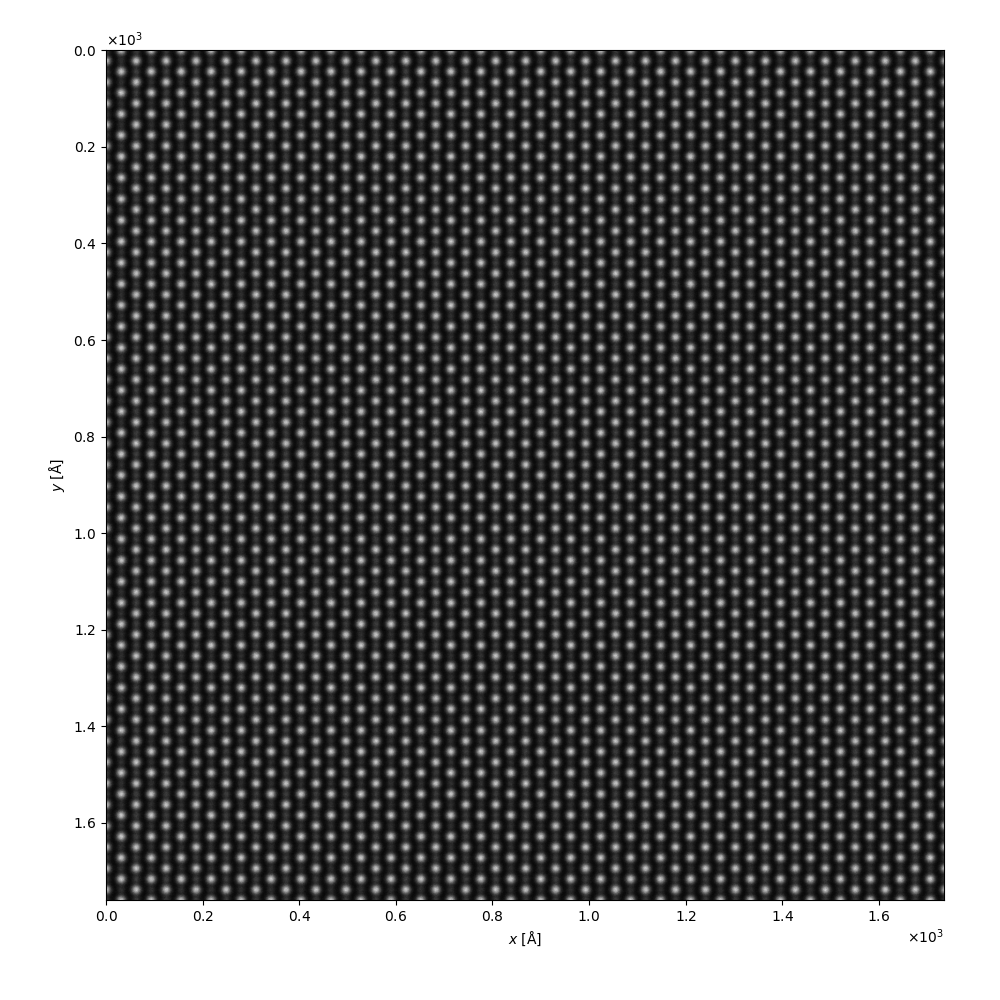

In [54]:
d = np.load('PbSe_HAADF_highI_large.npy')
plt.imshow(d,cmap='gray')
plt.show()